# Lecture 9: Intro to reservoir simulation and Monte Carlo methods
ENVR 890-001: Python for Environmental Research, Fall 2020

October 23, 2020

By Andrew Hamilton. Some material adapted from Greg Characklis, David Gorelick and H.B. Zeff.

## Summary
In this lecture, we will learn how to use **Monte Carlo methods** to account for uncertainty/probability in computer models. We will then build a model a **reservoir simulation model** and apply Monte Carlo to see how uncertainty propagates through the system.

## Monte Carlo (MC) methods
### Intro
***See hand-written notes pdf, Part 1, for introductory context***

### Implementation
Here we will implement the simple MC problem introduced in the notes.

First, assume we have estimated that daily PM10 concentrations in a particular region is approximately normally distributed with a mean ($\mu$) of 90 ug/m3 and a standard deviation ($\sigma$) of 20 ug/m3. We saw in the notes how to estimate the probability of violating the 150 ug/m3 standard on any particular day, and how to calculate the 95 percentile of PM10. Here is how to do that with MC sampling.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import normal, lognormal
from scipy.stats import skew, kurtosis

In [2]:
### define variables
mu = 90
sigma = 20
standard = 150
nsamples = 1000000

In [3]:
### sample from normal distribution
pm10 = normal(mu, sigma, size = nsamples)
pm10

array([73.79388249, 78.34759985, 60.71858382, ..., 76.19732966,
       75.46630053, 78.93912708])

Mean: 89.9903
Std: 20.0008
Skew: 0.0017
Excess Kurtosis: 0.0008


(array([2.00000e+00, 4.50000e+01, 2.78000e+02, 1.52000e+03, 6.18100e+03,
        2.02070e+04, 5.10840e+04, 1.02204e+05, 1.59103e+05, 1.95079e+05,
        1.86339e+05, 1.39313e+05, 8.23440e+04, 3.77360e+04, 1.36370e+04,
        3.91400e+03, 8.53000e+02, 1.43000e+02, 1.60000e+01, 2.00000e+00]),
 array([ -8.06598891,   1.91710618,  11.90020126,  21.88329634,
         31.86639142,  41.8494865 ,  51.83258158,  61.81567667,
         71.79877175,  81.78186683,  91.76496191, 101.74805699,
        111.73115207, 121.71424716, 131.69734224, 141.68043732,
        151.6635324 , 161.64662748, 171.62972256, 181.61281765,
        191.59591273]),
 <a list of 20 Patch objects>)

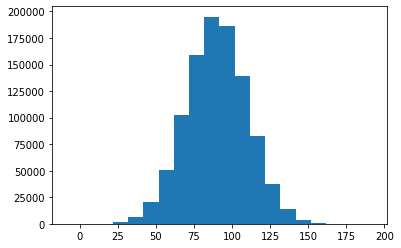

In [4]:
### get sample statistics & histogram. increase number of samples if necessary
print(f'Mean: {pm10.mean():.4f}')
print(f'Std: {pm10.std():.4f}')
print(f'Skew: {skew(pm10):.4f}')
print(f'Excess Kurtosis: {kurtosis(pm10):.4f}')
plt.hist(pm10, bins=20)

In [5]:
### probability of violating standard?
violations = pm10 > standard
print(violations)
print()

[False False False ... False False False]



In [6]:
prob_violation = violations.mean()
print(f'Probability of violation: {prob_violation:.4f}')

Probability of violation: 0.0013


In [7]:
### 95th percentile of pm10?
p95_pm10 = np.quantile(pm10, 0.95)
print(f'95th percentile: {p95_pm10:.4f} ug/m3')

95th percentile: 122.8782 ug/m3


Now consider the expected cardiovascular deaths based on pm10 from Lecture 4 (*note again that I made this up, not a real relationship*). 

$$deaths = \frac{15}{1 + \exp(-(PM10 - 80) / 35)}$$

We can very easily calculate statistics of interest for this quantity using our MC samples. This would be much more difficult to do analytically with pen and paper.

In [8]:
### equation for cardiovascular deaths as a function of pm10 (numpy compatible)
def get_deaths_pm10(pm10_array):
    return 15 / (1 + np.exp(- ( pm10_array - 80 ) / 35))

deaths = get_deaths_pm10(pm10)
deaths

array([6.83679561, 7.32299   , 5.48484274, ..., 7.09297135, 7.01492456,
       7.38634375])

Mean: 8.4892
Std: 1.9634
Skew: -0.1755
Excess Kurtosis: -0.3939


(array([   389.,   7679.,  40815., 109655., 194654., 247922., 225046.,
        133622.,  38036.,   2182.]),
 array([ 1.12098408,  2.4494819 ,  3.77797972,  5.10647754,  6.43497536,
         7.76347319,  9.09197101, 10.42046883, 11.74896665, 13.07746447,
        14.40596229]),
 <a list of 10 Patch objects>)

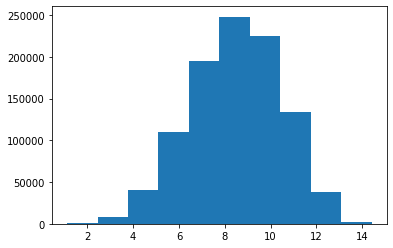

In [9]:
### look at distribution of deaths
print(f'Mean: {deaths.mean():.4f}')
print(f'Std: {deaths.std():.4f}')
print(f'Skew: {skew(deaths):.4f}')
print(f'Excess Kurtosis: {kurtosis(deaths):.4f}')
plt.hist(deaths)

In [10]:
### probability of more than 12 deaths?
deaths_g12 = deaths > 12
print(deaths_g12)
print()

[False False False ... False False False]



In [11]:
prob_deaths_gt12 = deaths_g12.mean()
print(f'Probability of >12 deaths: {prob_deaths_gt12:.4f}')

Probability of >12 deaths: 0.0272


In [12]:
### 95th percentile of pm10?
p95_deaths = np.quantile(deaths, 0.95)
print(f'95th percentile: {p95_deaths:.4f} deaths')

95th percentile: 11.5944 deaths


## Reservoir simulation
### Intro
***See hand-written notes pdf, Part 2, for introductory context***

***Pick up here after notes Part 2 (sorry, my ipad died in the middle of writing the notes "live" in class)***

(inflow + precip) - (release + evap) = change in storage

change in storage = storage_t - storage_{t-1}

assume precip = evap = 0

storage_t - stoarge{t-1} = inflow - release

storage_t = storage_{t-1} + inflow - release

Assume storage_0 = 1 million acre-feet (MAF)
       inflow = 0.2 MAF
       demand = 0.4 MAF
       
       storage_1 = 0.8 MAF
       
Problems: negative storage.
        release = demand
        storage_t = storage_{t-1} + inflow - release
        check if stoarage_t < 0, if so:
            release = release + storage_t
            storage_t = 0

Assume storage_0 = 1 million acre-feet (MAF)
       inflow = 0.6 MAF
       demand = 0.4 MAF
       
       storage_1 = 1.2 MAF
       
Problem: define max storage as storage_max = 2 MAF
        check if storage_t > storage_max, if so:
            release += (storage_t - storage_max)
            storage = storage_max
            
Other complications which we won't cover in this class: 
    Min storage (dead storage)
    Min lake level (recreation)
    Min outflow environmental
            
        

### In-class exercises
**Implementing a deterministic model**
Consider, as in the notes, a reservoir with a maximum storage capacity of 2 MAF. 

**Exercise 1**: Write a function that will take as inputs the current storage, inflow, and demand, and return the reservoir release and the updated storage. Make sure that it works in both of the important edge cases: (1) when there is not enough water to meet demand, and (2) when the reservoir runs out of storage capacity.

**Exercise 2**: Assume that current storage is 1 MAF and that demand each year is equal to 0.5 MAF per year. Use a while loop to answer the following two questions: (1) If inflows are equal to 0.3 MAF/year, in which year will we first be unable to meet our demand? (2) If inflows are 0.6 MAF/year, in which year will we first spill excess water?

**Exercise 3:** Use a for loop to simulate the reservoir system over 20 years, and store the inflow, demand, release, and storage at each time step. Store the results in a NumPy array, and then plot all 4 outputs on the same plot. Do this for both inflow scenarios.

**Implementing an uncertain model with Monte Carlo sampling**

**Exercise 4**: In reality, inflows will vary stochastically from year to year. Repeat exercise 3, but with inflows that are sampled from a lognormal distribution with a mean of -1 and a standard deviation of 0.7 (remember these parameters are in log space).

**Exercise 5**: Now suppose we are interested in a probabilistic assessment of possible outcomes over 20 years. We don't just want to run a single 20-year simulation, but rather to run a Monte Carlo analysis of the *entire simulation*.
- Run 1000 simulations of 20-years each. Store the inflow, demand, release, and storage for each year in a 1000x20x4 NumPy array.

- Calculate the final storage in year 20. What are the mean and std? Plot a histogram.

- Calculate the distribution of water deficit fractions ((demand minus release)/demand). What are the mean and 95th percentile?